# Transferêria de arte com Deep Learning e Tensorflow

Tranferência de arte é a ação de inserir uma estilo artístico em qualquer outra imagem sem alterar o seu conteúdo.

Com o surgimento das Redes Neurais Convolacionais, essas atividades que antes só eram possível ser feitas por um artística, agora podem ser feitas por qualquer computador.

## O que é uma rede neural convolucional?

A redes neurais convolucionais é um tipo de rede neural que é bastante utilizado na classificação de imagens, mas não se limitando só nelas, por se diferenciar das demais por conter as chamadas 'janelas deslizantes' que consegue retirar recursos de objetos que são construídos por sinais, que nem são os casos das imagens.

<img src='notebook_images/cnn.png'>

<small> Esse algoritmo é baseado no artigo <a href="https://arxiv.org/pdf/1508.06576.pdf"><i>A Neural Algorithm of Artistic Style, 2015</i></a> de Leon A. Gatys, Alexandre S. Eker e Mathias Bethge. </small>

### Importações necessárias

In [1]:
import numpy as np
from PIL import Image
import IPython.display
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

In [2]:
tf.enable_eager_execution() # Facilitar vizualição com tensorflow

### Carregando as imagens

As imagens que serão utilizadas aqui são do Palacio do Planalto, que será mantida o conteúdo, e A Noite Estrelada de Van Gogh, que será extraído o estilo

In [3]:
content_path = "content_images/planalto.jpg"
style_path = "style_images/van gogh.jpg"

In [4]:
def load_image(path):
    size = (512,512)
    img = load_img(path=path, target_size=size)
    img = img_to_array(img)
    
    img = np.expand_dims(img, axis=0)
    
    return img

In [5]:
content = load_image(content_path)
style = load_image(style_path)

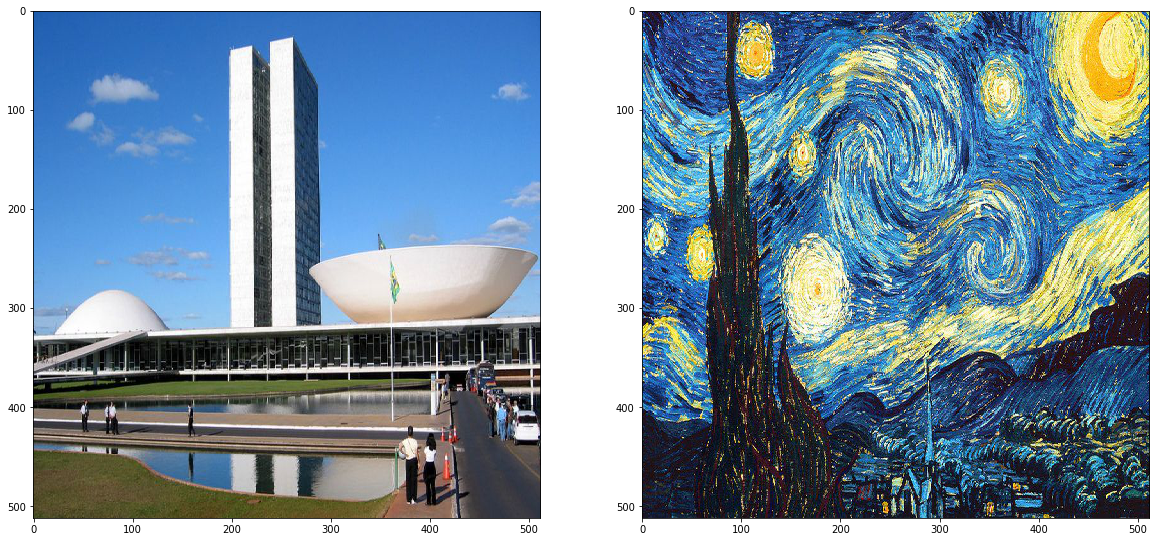

In [6]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(content).astype('int'))
plt.subplot(1,2,2)
plt.imshow(np.squeeze(style).astype('int'))

### Carregando Modelo Pré-Treinado

Aqui será utilizado um modelo de CNN já pré treinado do Keras, conhecido como VGG19 que foi treinado no imagenet. 

O modelo que vamos gerar a partir desse, vai conter só as camadas que serão escolhidas para a geração da nova imagem

In [7]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                       'block2_conv1',
                       'block3_conv1',
                       'block4_conv1','block5_conv1']

In [8]:
def get_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    style_output = [vgg.get_layer(name).output for name in style_layers]
    content_output = [vgg.get_layer(name).output for name in content_layers]
    model_output = style_output + content_output

    return Model(vgg.input, model_output)

In [9]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Funções de perda

Em uma rede neural, é ulizado a função de perda para calcular a distância entre o que a rede neural deu como resposta e a resposta original e então é reajustado os pesos da rede até encontrar o valor mínimo para o erro.

Na tranferência de arte a idéia é a mesma mas aplicado para ajustar a imagem.


parâmetros para enteder as equações:

N - número de filtros

M - tamanho da imagem x largura da imagem. 

F - M*N da imagem gerada (contém os recursos da imagem)

P - M*N do contéudo ou do estilo (contém os recursos da imagem)


#### Perda de conteúdo

A perda de conteúdo é dado pela distância entre os recursos da imagem gerada e a os recursos da imagem de conteúdo.

É cálculado por erro quadrático médio

<img src="notebook_images/content_loss.png" height="250" width="350">

In [10]:
def get_content_loss(current ,target):
    return tf.reduce_mean(tf.square(current-target))

#### Perda de estilo

A perda de estilo não é tão simples quanto a perda de conteúdo.

Para calcular a distância entre os estilos é primeiramente gerada uma nova matriz a partir da multiplição da matriz de recursos pela transporta dessa matriz

<img src="notebook_images/gram_mat.png" height="100" width="200">

In [11]:
def get_gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    feature_matrix = tf.reshape(tensor, [-1, channels])
    n = tf.shape(feature_matrix)[0]
    gram_matrix = tf.matmul(feature_matrix, feature_matrix, transpose_a=True)
    return gram_matrix / tf.cast(n, tf.float32)

Após isso é só calcular o erro quadrático médio entre essa duas matrizes

<img src="notebook_images/style_loss.png" height="250" width="350">

In [12]:
def get_style_loss(current, gram_target):
    gram_current = get_gram_matrix(current)
    return tf.reduce_mean(tf.square(gram_current-gram_target))

Com os dois erros já calculados é preciso então calcular o erro total para então ajustar a imagem gerada

Aplica-se então um coenficiente alfa e um beta para o conteúdo e o estilo que influenciam na hora de ajustar a imagem gerada

<img src="notebook_images/total_loss.png" height="250" width="350">

In [13]:
def loss_calculation(model, image, content_feature, style_features, alpha=1e3, beta=1e-2):
    
    image_output = model(image)
    
    image_styles = [style_layer[0] for style_layer in image_output[:len(style_layers)]]
    image_content = [content_layer[0] for content_layer in image_output[len(style_layers):]]
    
    style_score = 0
    content_score = 0
    
    weight = 1.0 / float(len(style_layers))
    
    for image_style, gram_target_style in zip(image_styles,style_features):
        style_score += weight*get_style_loss(image_style,gram_target_style)
        
    content_score = get_content_loss(image_content[0], content_feature[0])
    
    total_loss = (alpha*content_score) + (beta*style_score)

    return total_loss

In [14]:
def load_preprocess_image(path):
    img = load_image(path)
    img = preprocess_input(img)
    
    return img

def deprocess_img(processed_img):
    
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [15]:
def style_transfer(content_path, style_path, iterations=1001):
    
    # Carregar imagens pré processadas
    content_image = load_preprocess_image(content_path)
    style_image = load_preprocess_image(style_path)
    generated_img = load_preprocess_image(content_path)
    
    generated_img = tfe.Variable(generated_img, dtype=tf.float32)
    
    # Iniciar modelo desabilitando o treinamento dele e das camadas
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
    
    # Retonar só as saídas que foram selecionadas pro modelo
    style_outputs = model(style_image) 
    content_outputs = model(content_image)
 
    # Busca dos recursos
    style_features = [style_layer[0] for style_layer in style_outputs[:len(style_layers)]]
    content_features = [content_layer[0] for content_layer in content_outputs[len(style_layers):]]

    # Geração da Gram Matrix
    grams_feature_style = [get_gram_matrix(style_feature) for style_feature in style_features]
    
    # Otimizador - Adam (mostra os melhores resultados)
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    params = {
        "model": model,
        "image": generated_img,
        "content_feature": content_features,
        "style_features": grams_feature_style
    }
    
    # Necessário para mostrar a imagem
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
    
    
    for i in range(iterations):
        
        with tf.GradientTape() as t:
            loss = loss_calculation(**params) # Registra todos os passos para chegar ao resultado
        grad = t.gradient(loss, params['image']) # calula o gradiente descendente
        
        opt.apply_gradients([(grad,generated_img)])
        
        clipped = tf.clip_by_value(generated_img, min_vals, max_vals)
        generated_img.assign(clipped)
            
        if i % 100 == 0:
            image_out = deprocess_img(generated_img.numpy())
            IPython.display.clear_output(wait=True)
            print("Número de iterações: {}".format(i))
            IPython.display.display_png(Image.fromarray(image_out))
                
    Image.fromarray(image_out).save("Resultado.bmp")

Número de iterações: 1000


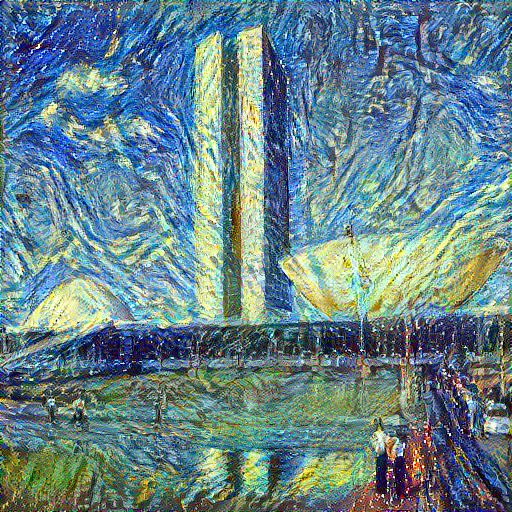

In [16]:
style_transfer(content_path, style_path)